## Weather data fetch and preprocessing notebook for MeteoVelo project

**Raw data that was fetched**

Hourly weather data for Paris, France were fetched from [open-meteo.org](https://open-meteo.com/en/docs/historical-weather-api) historical weather API using the time range of January 1 2019 to December 31 2024.

**Hourly Weather Variables**

- temperature_2m
- precipitation
- cloud_cover
- wind_speed_10m
- rain
- snowfall
- is_day
- weather_code
- snow_depth
- apparent_temperature
- relative_humidity_2m
- wet_bulb_temperature_2m
- sunshine_duration

In [1]:
# load libraries
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import sys
from pathlib import Path

# define directory variables
REPO_ROOT = Path.cwd().parent
DATA_DIR = REPO_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

In [35]:
# Optional API call to open-meteo.com to fetch the weather data
# This block is based on code provided by open-meteo.com's historical weather API interface 
# The original API call is cached as a .csv file

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 48.8534,
	"longitude": 2.3488,
	"start_date": "2019-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "precipitation", "cloud_cover", "wind_speed_10m", "rain", "snowfall", "is_day", "weather_code", 
               "snow_depth", "apparent_temperature", "relative_humidity_2m", "wet_bulb_temperature_2m", "sunshine_duration"],
	"timezone": "Europe/Berlin",
	"utm_source": "chatgpt.com",
}

# OPTIONAL API call.  Remove hashtag, if needed ################################################# ADJUST IF NEEDED
# responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_is_day = hourly.Variables(6).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(7).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(8).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(9).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(10).ValuesAsNumpy()
hourly_wet_bulb_temperature_2m = hourly.Variables(11).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(12).ValuesAsNumpy()

# set up dataframe with desired time zone formating for join with bike count data
tz = "Europe/Paris"
start = pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(tz)
end   = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True).tz_convert(tz)

hourly_data = {
    "date_time": pd.date_range(
        start=start,
        end=end,
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left",
    )
}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["is_day"] = hourly_is_day
hourly_data["weather_code"] = hourly_weather_code
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["wet_bulb_temperature_2m"] = hourly_wet_bulb_temperature_2m
hourly_data["sunshine_duration"] = hourly_sunshine_duration

external_weather_df = pd.DataFrame(data = hourly_data)

# Optional: write feteched data to .csv ################################################# ADJUST IF NEEDED
# external_weather_df.to_csv(DATA_DIR / "external"/ "fetched_hourly_weather_data.csv", index=False)

Coordinates: 48.82249450683594°N 2.288135528564453°E
Elevation: 43.0 m asl
Timezone: b'Europe/Berlin'b'GMT+1'
Timezone difference to GMT+0: 3600s


### weather_category variable

Open-Meteo provides a reduced set of WMO-style weather condition codes derived from cloud cover and precipitation. These codes were grouped into behaviorally meaningful categories (rain, snow, freezing precipitation, fog) for analysis.

In [2]:
# read in fetched hourly weather data
weather_df = pd.read_csv(DATA_DIR / "external" / "fetched_hourly_weather_data.csv")

# weather code loop-up for join
wmo_weather_code_lookup = pd.read_csv(DATA_DIR / "reference" /"open_meteo_wmo_code_table.csv")
wmo_weather_code_lookup = wmo_weather_code_lookup[['weather_code', 'weather_category']] #including weather_category only for join

# join weather_category labels to hourly data
weather_df = weather_df.merge(wmo_weather_code_lookup, on='weather_code', how='left')

# type weather_category as categorical
weather_df['weather_category'] = weather_df['weather_category'].astype('category')

### Additional binary variables

A set of derived binary variable were appended for convenience.

- ice_risk estimates whether or not there is elevated risk of ice on the road based on wet bulb temperature measurement. 
- other variables coded withing the is_[weather_category] columns refer to the presence of a particular weather category.

In [3]:
# conditions that have an elevated risk of ice
weather_df['ice_risk'] = weather_df['wet_bulb_temperature_2m'] <= 1 

# binary versions of weather_category
weather_df["is_clear_cloudy"] = weather_df["weather_category"].isin(["clear_cloudy"])
weather_df["is_fog"] = weather_df["weather_category"].isin(["fog"])
weather_df["is_rain"] = weather_df["weather_category"].isin(["rain"])
weather_df["is_freezing_precipitation"] = weather_df["weather_category"].isin(["freezing_precipitation"])
weather_df["is_snow"] = weather_df["weather_category"].isin(["snow"])

display(weather_df)

,date_time,temperature_2m,precipitation,cloud_cover,wind_speed_10m,rain,snowfall,is_day,weather_code,snow_depth,...,relative_humidity_2m,wet_bulb_temperature_2m,sunshine_duration,weather_category,ice_risk,is_clear_cloudy,is_fog,is_rain,is_freezing_precipitation,is_snow
0,2019-01-01 00:00:00+01:00,6.60,0.0,100.0,5.771239,0.0,0.0,0.0,3.0,0.0,...,91.409256,5.701492,0.0,clear_cloudy,False,True,False,False,False,False
1,2019-01-01 01:00:00+01:00,6.10,0.0,63.0,6.120000,0.0,0.0,0.0,2.0,0.0,...,94.283840,5.473268,0.0,clear_cloudy,False,True,False,False,False,False
2,2019-01-01 02:00:00+01:00,6.40,0.0,87.0,4.829907,0.0,0.0,0.0,3.0,0.0,...,91.714470,5.532126,0.0,clear_cloudy,False,True,False,False,False,False
3,2019-01-01 03:00:00+01:00,6.20,0.0,96.0,4.024922,0.0,0.0,0.0,3.0,0.0,...,92.021550,5.362685,0.0,clear_cloudy,False,True,False,False,False,False
4,2019-01-01 04:00:00+01:00,6.05,0.0,100.0,5.623380,0.0,0.0,0.0,3.0,0.0,...,92.333510,5.242973,0.0,clear_cloudy,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52603,2024-12-31 19:00:00+01:00,5.15,0.0,96.0,15.539537,0.0,0.0,0.0,3.0,0.0,...,88.153760,3.978520,0.0,clear_cloudy,False,True,False,False,False,False
52604,2024-12-31 20:00:00+01:00,5.15,0.0,100.0,16.119800,0.0,0.0,0.0,3.0,0.0,...,88.465260,4.006069,0.0,clear_cloudy,False,True,False,False,False,False
52605,2024-12-31 21:00:00+01:00,5.40,0.0,100.0,16.450070,0.0,0.0,0.0,3.0,0.0,...,88.176210,4.225679,0.0,clear_cloudy,False,True,False,False,False,False
52606,2024-12-31 22:00:00+01:00,5.40,0.0,100.0,15.963270,0.0,0.0,0.0,3.0,0.0,...,89.425800,4.337197,0.0,clear_cloudy,False,True,False,False,False,False


---
## Data Sanity Checks

Given that open-meteo.org is a well-maintained public dataset and the project’s focus is on downstream analysis rather than data cleaning, I limited outlier investigation to basic sanity checks and visual inspection. No values were removed.

Generally, there were not missing values and the data fell within the expected distributions.

### Visualization of distributions

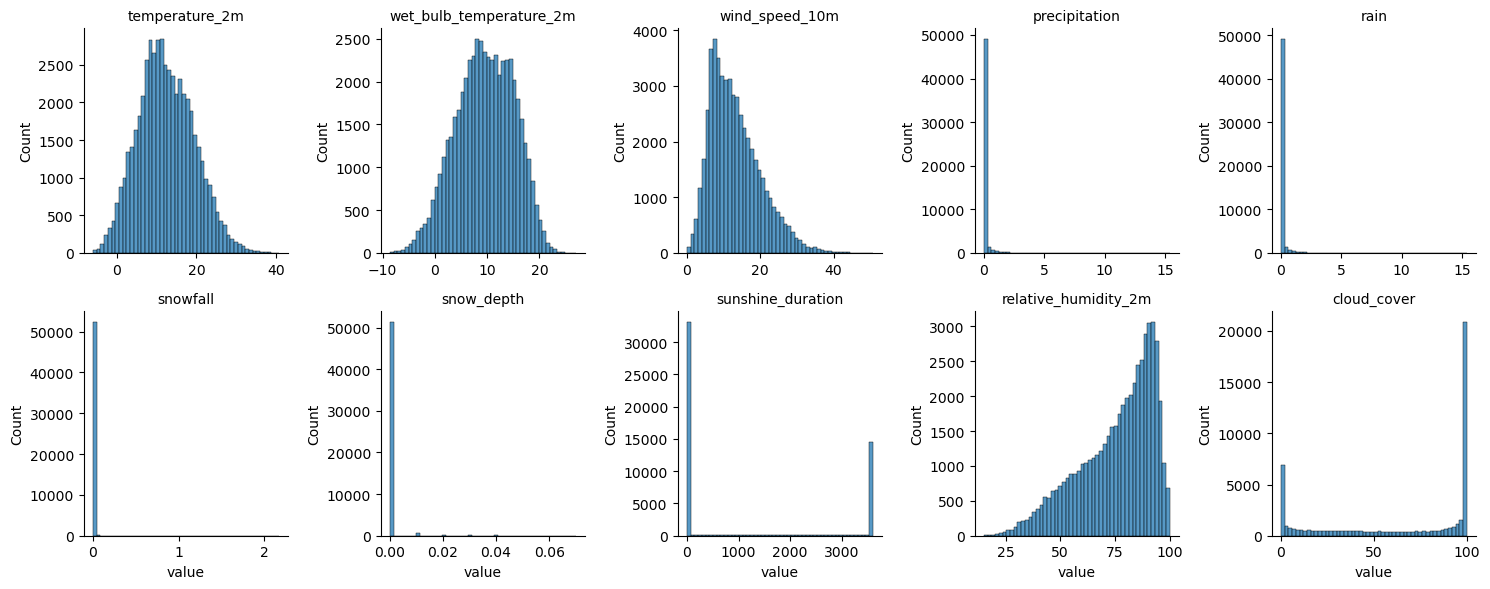

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

vars_to_plot = [
    "temperature_2m",
    "wet_bulb_temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "rain",
    "snowfall",
    "snow_depth",
    "sunshine_duration",
    "relative_humidity_2m",
    "cloud_cover",
]

df_long = weather_df[vars_to_plot].melt(var_name="variable", value_name="value")

g = sns.FacetGrid(
    df_long,
    col="variable",
    col_wrap=5,
    sharex=False,
    sharey=False,
    height=3
)

g.map_dataframe(
    sns.histplot,
    x="value",
    bins=50
)

g.set_titles("{col_name}")
g.tight_layout()
plt.show()

### Missingness

No missing values in weather_df

In [6]:
weather_df.isna().any().any()

False

### Weather Code Counts

Notably, snow was rare and freezing precipitation events were absent.

<Axes: xlabel='weather_category', ylabel='count'>

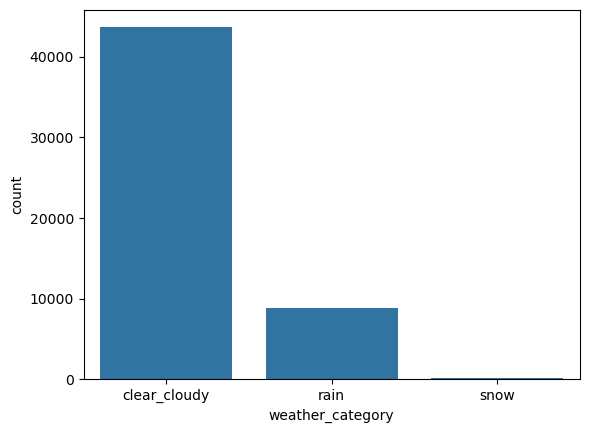

In [12]:
import seaborn as sns

sns.countplot(
    data= weather_df,
    x="weather_category",
    order=sorted(weather_df["weather_category"].unique())
)

In [42]:
weather_df.to_csv(DATA_DIR / "processed"/ "hourly_weather_data.csv", index=False)